 # Random Forest on MNIST dataset

In [1]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier



In [2]:
# Load MNIST dataset from OpenML
FILE_NAME = 'mnist.p'

if os.path.isfile(FILE_NAME):
    data = pickle.load(open(FILE_NAME, 'rb'))
else:
    data = fetch_openml('mnist_784', version=1)
    pickle.dump(data, open(FILE_NAME, 'wb'))
X = data.data
y = data.target.astype(np.int64)


In [3]:
# Rescaling to [-1, 1]
X_max = np.max(X)
X_min = np.min(X)
X = 1 - 2 * (X - X_min)/(X_max - X_min)



In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=10000)



In [5]:
SHOW_OUTPUTS = False
N_TREES = 10
EPSILON = 1e-4  # The minimum change to update a feature.
MAX_BUDGET = 0.2 * X.shape[1]   # The max. perturbation is allowed.
MAX_ITERATIONS = 100



In [6]:
class Path():
    """A Path is used by a single Decision Tree Estimator for a given input."""

    def __init__(self,
                 x,
                 feature_indices,
                 thresholds):
        self.x = np.squeeze(x)
        self.feature_indices = feature_indices
        self.thresholds = thresholds
        assert self.feature_indices.shape == self.thresholds.shape,             "feature_indices and thresholds should have same shape."
        self.visited_list = np.zeros(self.feature_indices.shape, dtype=bool)

    @property
    def last_unvisited_index(self):
        """The index of the last unvisited node."""
        # search from the end
        for i, is_visited in reversed(list(enumerate(self.visited_list))):
            if is_visited != True:
                return i
        return -1

    @property
    def last_node(self):
        """Returns the last unvisited node."""
        idx = self.last_unvisited_index
        if idx == -1:
            return None
        return {
            'feature_index': self.feature_indices[idx],
            'threshold': self.thresholds[idx]
        }

    @property
    def sign(self):
        """The direction of the cost."""
        node = self.last_node
        if node is None:
            return 1
        return 1 if self.x[node['feature_index']] <= node['threshold'] else -1

    @property
    def cost(self):
        """The absolute cost to switch the branch."""
        node = self.last_node
        if node is None:
            return np.inf
        return np.abs(self.x[node['feature_index']] - node['threshold']) + EPSILON

    def get_next_x(self):
        """The value is required to switch the branch."""
        node = self.last_node
        x = np.copy(self.x)
        if node is None:
            return x
        x[node['feature_index']] += self.sign * self.cost
        return x

    def visit_last_node(self):
        """Marks the last node as visited."""
        idx = self.last_unvisited_index
        self.visited_list[idx] = True



In [7]:
def build_paths(x, model, y):
    """Returns an array of paths with the correct prediction."""
    estimators = model.estimators_  # An array of DecisionTreeClassifier
    paths = []
    x = np.expand_dims(x, axis=0)
    for i, estimator in enumerate(estimators):
        pred = estimator.predict(x)
        if pred[0] != y[0]:  # Already misclassified, ignore this path
            continue
        # Get path indices
        # csr_matrix.nonzero() returns (row, col). We only need column indices.
        path_node_idx = estimator.decision_path(x).nonzero()[1]
        path_node_idx = path_node_idx[:-1]  # The last node is the output node

        # Find feature indices and thresholds
        tree = estimator.tree_
        feature_indices = np.array(tree.feature[path_node_idx])
        thresholds = np.array(tree.threshold[path_node_idx])

        path = Path(x, feature_indices, thresholds)
        paths.append(path)
    return paths



In [8]:
def find_next_path(paths, x_directions):
    """Finds the path with minimum cost."""
    min_cost = np.inf
    min_path = None
    for path in paths:
        if path.last_node is None:  # No viable node
            continue
        feature_idx = path.last_node['feature_index']
        # lowest cost and same direction (0 means it can go either way)
        if (min_cost > path.cost and
            (x_directions[feature_idx] == 0 or
             path.sign == x_directions[feature_idx])):
            min_cost = path.cost
            min_path = path
    return min_path



In [9]:
def compute_direction(x_stack, n_features):
    """Compute the direction of the updates on x"""
    x_directions = np.zeros(n_features, dtype=np.int64)
    if len(x_stack) >= 2:  # The 1st x is the input.
        x_directions = np.sign(x_stack[-1] - x_stack[0]).astype(np.int64)
    return x_directions



In [10]:
def random_forest_attack(model, x, y):
    """Generates an adversarial example from single input."""
    m = x.shape[1]  # Number of input features
    budget = MAX_BUDGET
    x_stack = [x.squeeze()]  # Expect format [[x0, x1, ...]]
    x_directions = np.zeros(m, dtype=np.int64)
    paths = build_paths(x_stack[0], model, y)
    paths_stack = [paths]  # Expect format [[path0, path1, ...]]

    for i in range(MAX_ITERATIONS):
        # Predict latest updated x
        if model.predict(np.expand_dims(x_stack[-1], axis=0))[0] != y[0]:
            return x_stack[-1].reshape(x.shape)

        # Pick a node
        least_cost_path = find_next_path(paths_stack[-1], x_directions)
        if (least_cost_path is None and
                len(paths_stack) == 1 and
                len(x_stack) == 1): # No more viable node at the root
            break

        while least_cost_path is None or budget < 0:
            # Current branch has no viable path. Go up!
            # Don't remove the root
            if len(paths_stack) > 1 and len(x_stack) > 1:
                paths_stack.pop()
                last_x = x_stack.pop()
            else:
                last_x = x_stack[0]

            # RESTORE: direction
            x_directions = compute_direction(x_stack, m)
            # RESTORE: budget
            change = last_x - x_stack[-1]
            budget += np.abs(np.sum(change))
            current_paths = paths_stack[-1]
            least_cost_path = find_next_path(current_paths, x_directions)

        # UPDATE: Order matters!
        # UPDATE 1) Append x
        next_x = least_cost_path.get_next_x()
        x_stack.append(next_x)
        # UPDATE 2) Reduce budget
        budget -= least_cost_path.cost
        # UPDATE 3) Update direction
        feature_index = least_cost_path.last_node['feature_index']
        x_directions[feature_index] = least_cost_path.sign
        # UPDATE 4) Append path
        # WARNING: After this call, the node with min cost will switch to the next least node.
        least_cost_path.visit_last_node()
        next_paths = build_paths(next_x, model, y)
        paths_stack.append(next_paths)

    print('Budget={}. Fail to find adversarial example from [[{}]]. Exit.'.format(
        budget, str(','.join(['{:5.2f}'.format(xx) for xx in x[0]]))))
    return x_stack[-1].reshape(x.shape)



In [11]:
# Train model
rf_model = RandomForestClassifier(n_jobs=-1, n_estimators=N_TREES)
rf_model.fit(X_train, y_train)



RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [12]:
print(rf_model.score(X_train, y_train))
print(rf_model.score(X_test, y_test))



0.99925
0.9444


In [13]:
SIZE = 100
X_adv = []
# Process one data point at a time
for i, (xx, yy) in enumerate(zip(X_test[:SIZE], y_test[:SIZE])):
    xx = np.expand_dims(xx, axis=0)
    yy = np.expand_dims(yy, axis=0).astype(np.int64)
    if SHOW_OUTPUTS:
        print('[{:3d}] {:11s}: X=[{}], y={}, pred={}'.format(
            i, 'Original',
            str(','.join(['{:5.2f}'.format(_x) for _x in xx[0]])),
            yy[0], rf_model.predict(xx)[0]))
    adv_x = random_forest_attack(rf_model, xx, yy)
    X_adv.append(adv_x.flatten())
    pred_adv = rf_model.predict(adv_x)[0]
    if SHOW_OUTPUTS:
        print('[{:3d}] {:11s}: X=[{}], y={}, pred={}'.format(
            i, 'Adversarial',
            str(','.join(['{:5.2f}'.format(_x) for _x in adv_x[0]])),
            yy[0], pred_adv))
    if not SHOW_OUTPUTS:
        print('[{:3d}] Clean label: {:2d}, Adv. label: {:2d}'.format(
            i, yy[0], pred_adv))



[  0] Clean label:  3, Adv. label:  4
[  1] Clean label:  4, Adv. label:  9
[  2] Clean label:  1, Adv. label:  8
[  3] Clean label:  5, Adv. label:  1
[  4] Clean label:  1, Adv. label:  8
[  5] Clean label:  0, Adv. label:  2
[  6] Clean label:  4, Adv. label:  6
[  7] Clean label:  4, Adv. label:  6
[  8] Clean label:  7, Adv. label:  2
[  9] Clean label:  4, Adv. label:  9
[ 10] Clean label:  2, Adv. label:  3
[ 11] Clean label:  5, Adv. label:  3
[ 12] Clean label:  8, Adv. label:  3
[ 13] Clean label:  1, Adv. label:  8
[ 14] Clean label:  1, Adv. label:  8
[ 15] Clean label:  1, Adv. label:  7
[ 16] Clean label:  9, Adv. label:  4
[ 17] Clean label:  4, Adv. label:  9
[ 18] Clean label:  9, Adv. label:  2
[ 19] Clean label:  6, Adv. label:  4
[ 20] Clean label:  9, Adv. label:  7
[ 21] Clean label:  3, Adv. label:  2
[ 22] Clean label:  2, Adv. label:  3
[ 23] Clean label:  6, Adv. label:  8
[ 24] Clean label:  7, Adv. label:  2
[ 25] Clean label:  5, Adv. label:  3
[ 26] Clean 

In [14]:
y_pred = rf_model.predict(X_test[:SIZE])
acc = np.count_nonzero(y_pred == y_test[:SIZE]) / len(y_test[:SIZE])
print('Accuracy on test set = {:.2f}%'.format(acc*SIZE))

adv_pred = rf_model.predict(np.array(X_adv))
acc = np.count_nonzero(adv_pred == y_test[:SIZE]) / len(y_test[:SIZE])
print('Accuracy on adversarial example set = {:.2f}%'.format(acc*SIZE))



Accuracy on test set = 96.00%
Accuracy on adversarial example set = 0.00%


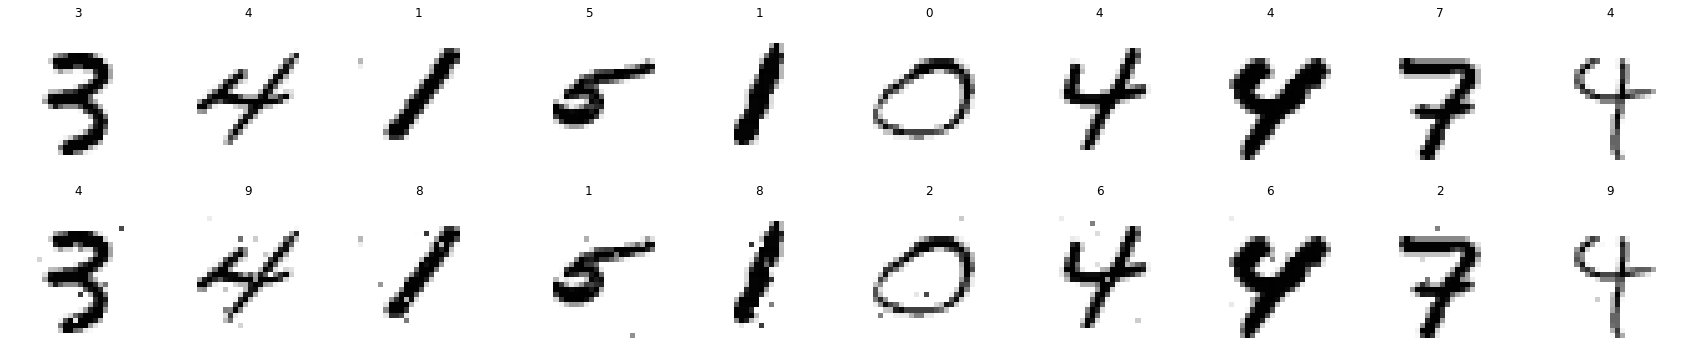

In [18]:
n_figs = 10
fig, axs = plt.subplots(nrows=2, ncols=n_figs,figsize=(n_figs*3, 2*3 ))

for i in range(n_figs):
    axs[0,i].imshow(X_test[i].reshape(28, 28), interpolation='none', vmin=-1.0, vmax=1.0, cmap=plt.cm.gray)
    axs[0,i].set_title(str(y_pred[i]))
    axs[0,i].axis('off')

    axs[1,i].imshow(X_adv[i].reshape(28, 28), interpolation='none', vmin=-1.0, vmax=1.0, cmap=plt.cm.gray)
    axs[1,i].set_title(str(adv_pred[i]))
    axs[1,i].axis('off')
fig.show()